### Notes

This script was inspired by an R script written on the https://www.opensourcefootball.com/ website.

**Reference:** https://www.opensourcefootball.com/posts/2020-08-19-neural-nets-using-r/


The goal is to build a neural network to predict yards after catch for NFL Receivers. There is nothing overly fancy here given that my goal is really just to improve my `python` skills and so I decided to take elements from the `R` neural network in the above line and try and apply it to `python`. As such, this is no where near and exhaustive treatment of neural networks but rather an intro (for me) into coding in `tensorflow` in `python`. In fact, the neural network might not even be the best way to answer this question and at the end I will use linear regression to build a model and predict YAC.

## Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Get Data

We will get the data from the `nflfastr`github page: https://github.com/guga31bb/nflfastR-data/tree/master/data

In [3]:
## set the years we are interested in obtaining
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [4]:
## Write a loop to extract the data for those years

pbp = pd.DataFrame()

for i in years:
        nfl_dat = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                   'play_by_play_' + str(i) + '.csv.gz?raw=true',
                  compression = 'gzip',
                  low_memory = False)
        
        pbp = pbp.append(nfl_dat, sort = True)

In [5]:
## Look at the first few rows

pbp.head()

,aborted_play,air_epa,air_wpa,air_yards,assist_tackle,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,...,xyac_median_yardage,xyac_success,yac_epa,yac_wpa,yardline_100,yards_after_catch,yards_gained,ydsnet,ydstogo,yrdln
0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,30.0,NaN,0.0,53.0,0,LA 30
1,0,-0.564643,-0.005659,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,6.0,0.690780,0.000000,0.000000,78.0,0.0,0.0,53.0,10,ARI 22
2,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,78.0,NaN,5.0,53.0,10,ARI 22
3,0,1.448654,0.033835,7.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.998045,0.758916,0.034915,73.0,11.0,18.0,53.0,5,ARI 27
4,0,-0.471865,-0.017380,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,6.0,0.692089,1.816268,0.053408,55.0,17.0,17.0,53.0,10,ARI 45


In [6]:
## Look at the column names

list(pbp.columns)

['aborted_play',
 'air_epa',
 'air_wpa',
 'air_yards',
 'assist_tackle',
 'assist_tackle_1_player_id',
 'assist_tackle_1_player_name',
 'assist_tackle_1_team',
 'assist_tackle_2_player_id',
 'assist_tackle_2_player_name',
 'assist_tackle_2_team',
 'assist_tackle_3_player_id',
 'assist_tackle_3_player_name',
 'assist_tackle_3_team',
 'assist_tackle_4_player_id',
 'assist_tackle_4_player_name',
 'assist_tackle_4_team',
 'away_coach',
 'away_score',
 'away_team',
 'away_timeouts_remaining',
 'away_wp',
 'away_wp_post',
 'blocked_player_id',
 'blocked_player_name',
 'comp_air_epa',
 'comp_air_wpa',
 'comp_yac_epa',
 'comp_yac_wpa',
 'complete_pass',
 'cp',
 'cpoe',
 'def_wp',
 'defensive_extra_point_attempt',
 'defensive_extra_point_conv',
 'defensive_two_point_attempt',
 'defensive_two_point_conv',
 'defteam',
 'defteam_score',
 'defteam_score_post',
 'defteam_timeouts_remaining',
 'desc',
 'div_game',
 'down',
 'drive',
 'drive_end_transition',
 'drive_end_yard_line',
 'drive_ended_with_

## Extract Passing Plays

In [7]:
## What are the values in the 'pass' column?

pbp['pass'].unique()

array([0, 1])

The values are binary with a 0 being "no pass" and a 1 being a "pass". Let's get all players where pass == 1

In [30]:
df = pbp[pbp['pass']== 1] 

## Data Pre-Processing

Make the pass location binary by specifying a "1" every time the pass is in the middle of the field or a "0" otherwise.

For this, I'll use the `where()` function from the `numpy` package, which seems to behave like `case_when()` in `R`.

In [31]:
df['pass_location'] = np.where(df.pass_location == 'middle', 1, 0)

/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The `roof` column tells us about what type of stadium the game is being played in.

In [32]:
df['roof'].unique()

array(['dome', 'outdoors', 'closed', 'open'], dtype=object)

The variable is of `dtype = object`. In the `R` script they change this column to a factor and in `python` I believe the equivalent is a `categorical`. So we will change the data type to `categorical`.

In [33]:
df['roof'] = df['roof'].astype('category')
df['roof'].unique()

/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[dome, outdoors, closed, open]
Categories (4, object): [dome, outdoors, closed, open]

Finally, we will constrain the analysis to only a few key columns that we believe will influence YAC (the same columns from the above line). We will then drop NA values from the data set and reset the indexes. We will then dummy code the categorical variable, `roof`.

In [34]:
df = df[['yardline_100', 'down', 'ydstogo', 'shotgun', 'air_yards', 'yards_after_catch', 'qb_hit', 'pass_location', 'roof']]
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df = pd.get_dummies(df, columns = ['roof'])

In [35]:
## Look at the new data set

df.head()

,yardline_100,down,ydstogo,shotgun,air_yards,yards_after_catch,qb_hit,pass_location,roof_closed,roof_dome,roof_open,roof_outdoors
0,78.0,1.0,10,0,0.0,0.0,0.0,0,0,1,0,0
1,73.0,3.0,5,1,7.0,11.0,0.0,0,0,1,0,0
2,55.0,1.0,10,1,0.0,17.0,0.0,0,0,1,0,0
3,36.0,2.0,8,1,12.0,0.0,0.0,0,0,1,0,0
4,32.0,1.0,10,0,13.0,0.0,0.0,0,0,1,0,0


How much data are we dealing with?

In [36]:
df.shape

(115605, 12)

115,605 rows and 12 columns

## Train/Test Split

Select the predictor variables, `X`, by dropping the target variable, `yards_after_catch`. Also, pre-process the `X` variables by scaling them to have a mean of 0 and variance of 1.

In [39]:
X = df.drop('yards_after_catch', axis = 1)
X = preprocessing.scale(X)
y = df['yards_after_catch']

Create a train/test split with the training set representing 90% of the data and the test set the remaining 10%.

In [40]:
sample_count = int(df.shape[0] * 0.9)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = sample_count, random_state=2378)

## Save Data in .npz format

This will be a two-tuple format of inputs and targets, which we will use in `tensorflow`.

**NOTE:** The data will be saved in this file format to your working directory.

In [ ]:
np.savez('yac_train', inputs = X_train, targets = y_train)
np.savez('yac_test', inputs = X_test, targets = y_test)

## Load the .npz files

In [41]:
train_npz = np.load('yac_train.npz')
train_inputs = train_npz['inputs'].astype(np.float)
train_targets = train_npz['targets'].astype(np.int)

test_npz = np.load('yac_test.npz')
test_inputs = test_npz['inputs'].astype(np.float)
test_targets = test_npz['targets'].astype(np.int)

## Create Neural Netowrk

#####  Model input information
1) State the number of predictors (in this case 11)

2) State the number of outputs (in this case 1)

3) Set the width of the hidden layers by specifying the number of units/nodes in each hidden layer (in this case I use 10)


In [43]:
n_predictors = 11
n_outputs = 1
hidden_layer_size = 10

##### Create the model

* I'm going to specificy 4 hidden layers (each with a size of 10, as indicated above)
* The optimizer I'll use is stochastic gradient descent
* I'll use mean squared error as my loss function and the metrics I want to evaluate my model on are mean squared error and mean absolute error

In [44]:
model = tf.keras.Sequential([  
    tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'),
    tf.keras.layers.Dense(n_outputs)       
])


model.compile(optimizer='sgd', loss='mean_squared_error', metrics = ['mae', 'mse'])

##### Specify the hyperparameters for batch size and epoch

* Batch size will indicate the number of training samples used in a single iteration
* Epoch will indicate the number of times the model will go through the training data set

In [47]:
batch_size = 100
max_epochs = 100

##### Run the model

In [53]:
model.fit(train_inputs,
         train_targets,
         batch_size = batch_size,
         epochs = max_epochs,
         verbose = 2)

Epoch 1/100
116/116 - 0s - loss: 41.5853 - mae: 4.0385 - mse: 41.5853
Epoch 2/100
116/116 - 0s - loss: 41.9163 - mae: 4.0677 - mse: 41.9163
Epoch 3/100
116/116 - 0s - loss: 41.6176 - mae: 4.0381 - mse: 41.6176
Epoch 4/100
116/116 - 0s - loss: 41.4838 - mae: 4.0392 - mse: 41.4838
Epoch 5/100
116/116 - 0s - loss: 41.5506 - mae: 4.0418 - mse: 41.5506
Epoch 6/100
116/116 - 0s - loss: 41.6051 - mae: 4.0532 - mse: 41.6051
Epoch 7/100
116/116 - 0s - loss: 41.6677 - mae: 4.0523 - mse: 41.6677
Epoch 8/100
116/116 - 0s - loss: 41.4794 - mae: 4.0370 - mse: 41.4794
Epoch 9/100
116/116 - 0s - loss: 41.5663 - mae: 4.0467 - mse: 41.5663
Epoch 10/100
116/116 - 0s - loss: 41.4974 - mae: 4.0433 - mse: 41.4974
Epoch 11/100
116/116 - 0s - loss: 41.5922 - mae: 4.0515 - mse: 41.5922
Epoch 12/100
116/116 - 0s - loss: 41.6230 - mae: 4.0511 - mse: 41.6230
Epoch 13/100
116/116 - 0s - loss: 41.5722 - mae: 4.0434 - mse: 41.5722
Epoch 14/100
116/116 - 0s - loss: 41.4559 - mae: 4.0342 - mse: 41.4559
Epoch 15/100
11

In the final iteration, we see a mean absolute error of 4.0453 and a mean squared error of 41.4034.

## Test the model

First get the model predictions on the test data set.

In [49]:
pred_YAC = model.predict(test_inputs)
pred_YAC = pd.DataFrame(pred_YAC, columns = ['Pred'])
pred_YAC.head()

,Pred
0,3.933353
1,5.350162
2,3.171444
3,4.393558
4,3.684061


In [50]:
# Convert the predictions from a data frame into a string

predictions = pred_YAC['Pred']

Now get the actual values of YAC observed in the data set.

In [55]:
test_YAC = pd.DataFrame(test_targets, columns = ['Obs_YAC'])
actual = test_YAC['Obs_YAC']

Calulate the residual between observed and predicted

In [52]:
resid = actual - predictions

Plot the residuals

Text(0.5, 1.0, 'Histogram of Residuals')

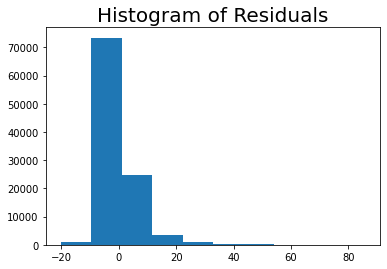

In [59]:
plt.hist(resid)
plt.title('Histogram of Residuals', size = 20)

Calculate the mean absolute error on the test data

In [61]:
mae = resid.abs().mean()
mae

4.158478421594513

Calculate the mean squared error on the test data

In [62]:
sq_resid = resid ** 2
mse = sq_resid.mean()
mse

44.9336538832123

The results on the test data seem competitive with (though slightly worse than) the results in the final iteration of the training data.

## Linear Regression

As I said at the start, the exercise of writing the neural network was to work on improving my `python` skills (as I mainly work in `R` and have done so for the last 8 years). Thus, I didn't believe that a neural network was the best tool for this analysis (though it is the most fancy). As such, I'll now build a linear regression model and see what type of results I can get.

I'll buld the regression model in both the `sklearn` and `statsmodels` packages. I do this because, while the former seems to be the most preferred approach for `python` coders, it frustrates me because I have a hard time getting the output about the model that I would like (though this may be more on me given my lack of understanding of a lot of `python`). Conversely, the latter provides a nice model output so that you can understand what went on under the hood.

### Regression in sklearn

In [64]:
from sklearn import linear_model as lm

Recall that we have already created our train and test splits above, so I will simply use those.

In [118]:
# First create a linear regression instance
lm.model = lm.LinearRegression()

# Now create the linear model
fit_sklearn = lm.model.fit(X_train, y_train)

Print the model coefficients

In [119]:
fit_sklearn.intercept_, fit_sklearn.coef_

(5.1565691970456955,
 array([ 0.00000000e+00,  7.98104832e-01,  1.02404253e-01,  3.77836187e-01,
        -2.34585021e-01, -9.50577574e-01,  3.46594785e-02, -1.31089643e-01,
        -2.92473726e+12, -3.06674584e+12, -1.10461171e+12, -3.98163106e+12]))

This is useless as there are no varibale names. Let's just look at the coefficients with their column names.

In [79]:
value = fit_sklearn.coef_
coef = ['yardline_100', 'down', 'ydstogo', 'shotgun', 'air_yards', 'qb_hit', 'pass_location', 'roof_closed', 'roof_dome', 'roof_open', 'roof_outdoors']
pd.DataFrame(value, coef)

,0
yardline_100,7.978854e-01
down,1.014954e-01
ydstogo,3.761414e-01
shotgun,-2.364584e-01
air_yards,-9.484371e-01
qb_hit,3.368871e-02
pass_location,-1.298373e-01
roof_closed,8.850522e+12
roof_dome,9.280253e+12
roof_open,3.342656e+12


Make Predictions on the test set

In [81]:
preds = fit_sklearn.predict(X_test)

Calculate the residual

In [83]:
resid = y_test - preds

Plot the residuals

Text(0.5, 1.0, 'Histogram of Residuals')

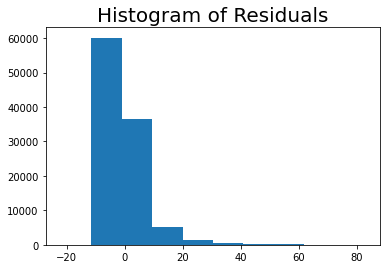

In [84]:
plt.hist(resid)
plt.title("Histogram of Residuals", size = 20)

Calculate the mean absolute error

In [85]:
mae = resid.abs().mean()
mae

4.542613084974376

Calculate the mean squared error

In [86]:
sq_resid = resid ** 2
mse = sq_resid.mean()
mse

49.097402620785836

We see that the regression performed slightly worse than the neural network did. The absolute error for the neural network on the test set was 4.2 while the absolute error for the linear regression was 4.5. Not a massive difference for a much simpoler and easier to interpret model! But as they say....*"It's a game of inches!"*

### Regression in statsmodels

Now I'll build the same regression model on the training set in the `statsmodels1` package. As you will see, the output of the regression model is much easier to look at than the array of coefficients that `sklearn` kicks out.

In [89]:
import statsmodels.api as smf

Before building the model we need to add a `constant` term to the `X_train` data set. This will ensure that `statsmodels` includes an intercept in our model as it doesn't automatically add one.

In [113]:
X_train = smf.add_constant(X_train)

Build the regression model.

In [115]:
fit_statsmodels = smf.OLS(y_train, X_train).fit()

Get the nice looking summary of the model.

In [116]:
fit_statsmodels.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      yards_after_catch   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     42.81
Date:                Thu, 27 Aug 2020   Prob (F-statistic):           4.03e-84
Time:                        17:36:32   Log-Likelihood:                -38720.
No. Observations:               11561   AIC:                         7.746e+04
Df Residuals:                   11550   BIC:                         7.754e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1635      0.064     80.514      0.000       5.038       5.289
x1             0.7979      0.065     12.226      0.000       0.670       0.926
x2             0.1015      0.069      1.463      0.144      -0.035       0.238
x3             0.3769      0.068      5.527      0.000       0.243       0.511
x4            -0.2357      0.067     -3.505      0.000      -0.368      -0.104
x5            -0.9492      0.065    -14.616      0.000      -1.076      -0.822
x6             0.0353      0.065      0.547      0.584      -0.091       0.162
x7            -0.1303      0.065     -2.011      0.044      -0.257      -0.003
x8             0.0575      0.049      1.162      0.245      -0.039       0.155
x9            -0.0139      0.048     -0.290      0.772      -0.108       0.080
x10           -0.0528      0.062     -0.851      0.395      -0.174       0.069
x11           -0.0169      0.035     -0.482      0.629      -0.086       0.052
==============================================================================
Omnibus:                     8846.156   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           233664.633
Skew:                           3.471   Prob(JB):                         0.00
Kurtosis:                      23.902   Cond. No.                     3.13e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.17e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Make Prededictions on the test set

In [122]:
## set an intercept/constant
X_test = smf.add_constant(X_test)

## make predictions
preds = fit_statsmodels.predict(X_test)

Calculate the residual

In [123]:
resid = y_test - preds

Plot the residuals

Text(0.5, 1.0, 'Histogram of Residuals')

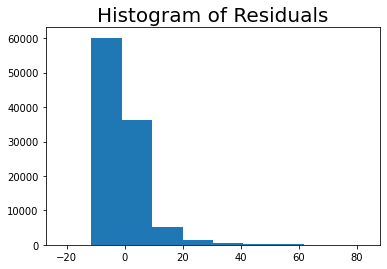

In [124]:
plt.hist(resid)
plt.title("Histogram of Residuals", size = 20)

Calculate mean absolute error

In [125]:
mae = resid.abs().mean()
mae

4.5361872627598965

Calculate mean squared error

In [126]:
sq_resid = resid ** 2
mse = sq_resid.mean()
mse

49.098360483784845